In [1]:
library(tidyverse)
library(tidymodels)
library(psych)
library(ROSE)
company <- read.csv(file = '../input/company-bankruptcy-prediction/data.csv' , header = T)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.1.3 ──

✔ broom        0.7.6      ✔ rsample      0.0.9 
✔ dials        0.0.9      ✔ tune         0.1.3 
✔ infer        0.5.4      ✔ workflows    0.2.2 
✔ modeldata    0.1.0      ✔ workflowsets 0.0.2 
✔ parsnip      0.1.5      ✔ yardstick    0.0.8 
✔ recipes      0.1.16     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spe

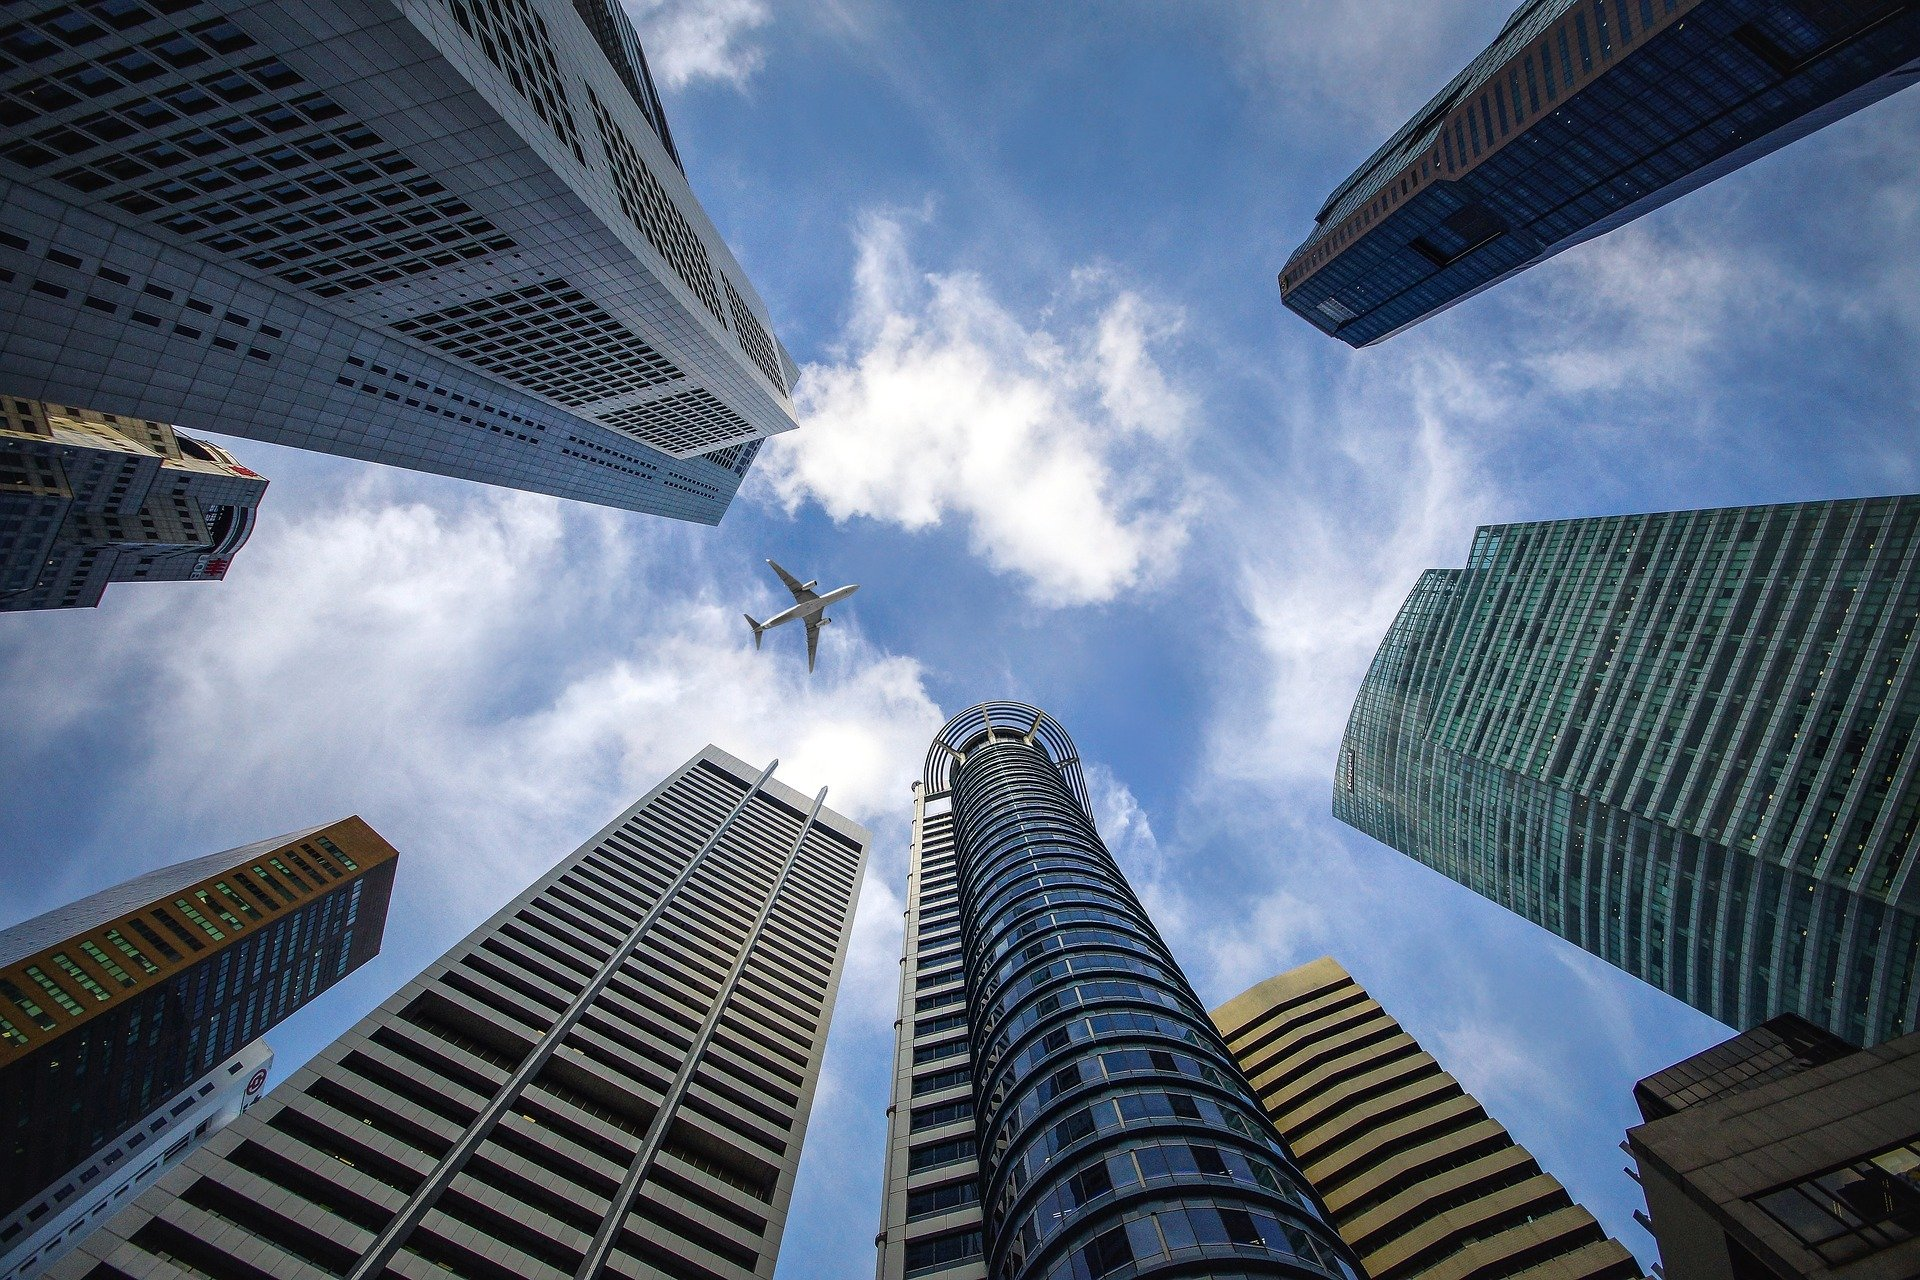

# Introduction

The goal of the analysis with this data is obvious. Classifying the binary dependent variable. There seems not to be other goal since the data is really difficult to understand(to whom doesn't have economical knowledge). I couldn't draw any insight as i didn't understand the bunch of variables. There was nothing I could do but modeling for prediction.

### Goal

But we need to think about the goal of prediction. Let's suppose you want to invest in stocks. If you predicted a company to go bankrupt but it didn't , it doesn't matter because you didn't invest into the company. But in the opposite situation, it's huge problem. Therefore, forecasting bankruptcy is more important. 

# Preprocess

There are some trivial jobs you have to do before modeling.

In [2]:
company %>% select(where(is.integer)) %>% colnames() #Which variable is binary?
company$Bankrupt. <- factor(company$Bankrupt. , levels = c(0,1) ,labels = c('NO' , 'YES'))
company %>% select(-where(is.integer)) -> company

#company$Liability.Assets.Flag <- factor(company$Liability.Assets.Flag, levels = c(0,1) , labels = c('NO', 'Exceeds'))
#company$Net.Income.Flag <- factor(company$Net.Income.Flag , levels = c(0,1) , labels = c('NO' , 'Negative'))
#Factorize binary variables with label.

[1] "Bankrupt."             "Liability.Assets.Flag" "Net.Income.Flag"

🔔I just factorized binary variables at first but during analysis, I realized just removing them would be better. So i did.


Actually, the data has some problems. 

### Outliers

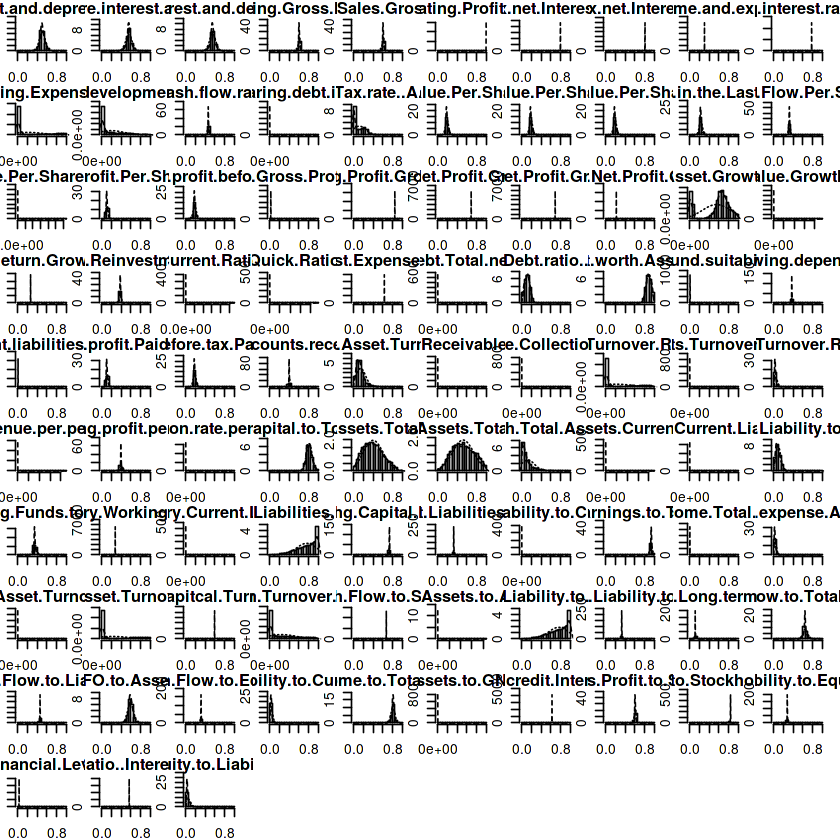

In [3]:
company %>% select(where(is.numeric)) %>% multi.hist()

As you can see, the plot is kind of weird.

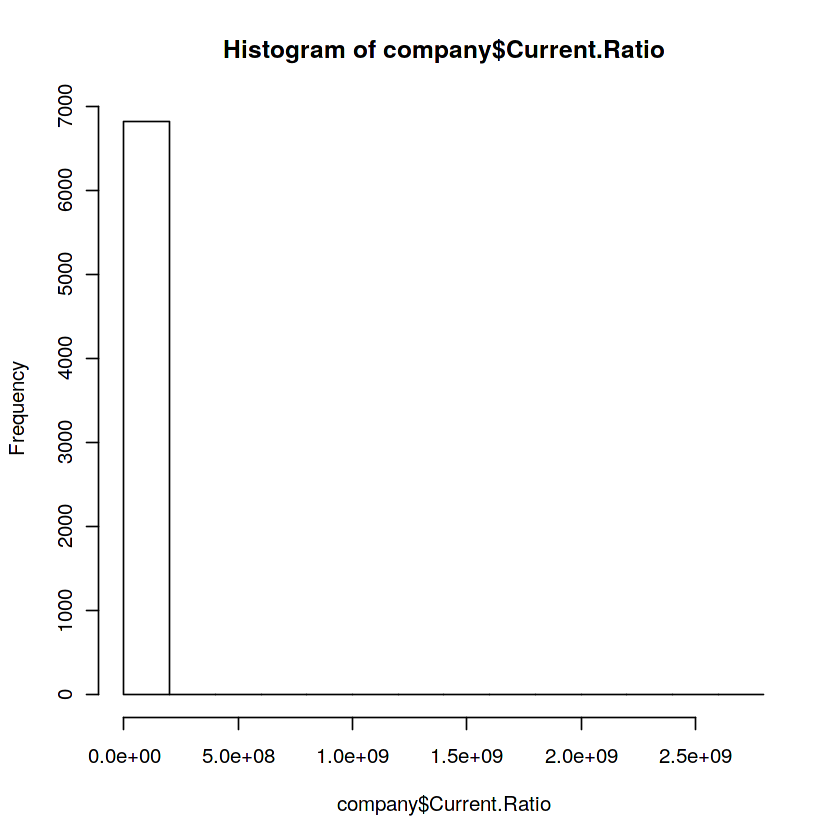

In [4]:
hist(company$Current.Ratio)

The variable is ratio. But there is an observation over 2.5e+09! It's an obvious error. You need to remove extreme values like this. But there are too many variables to check. So algorithm must be used.

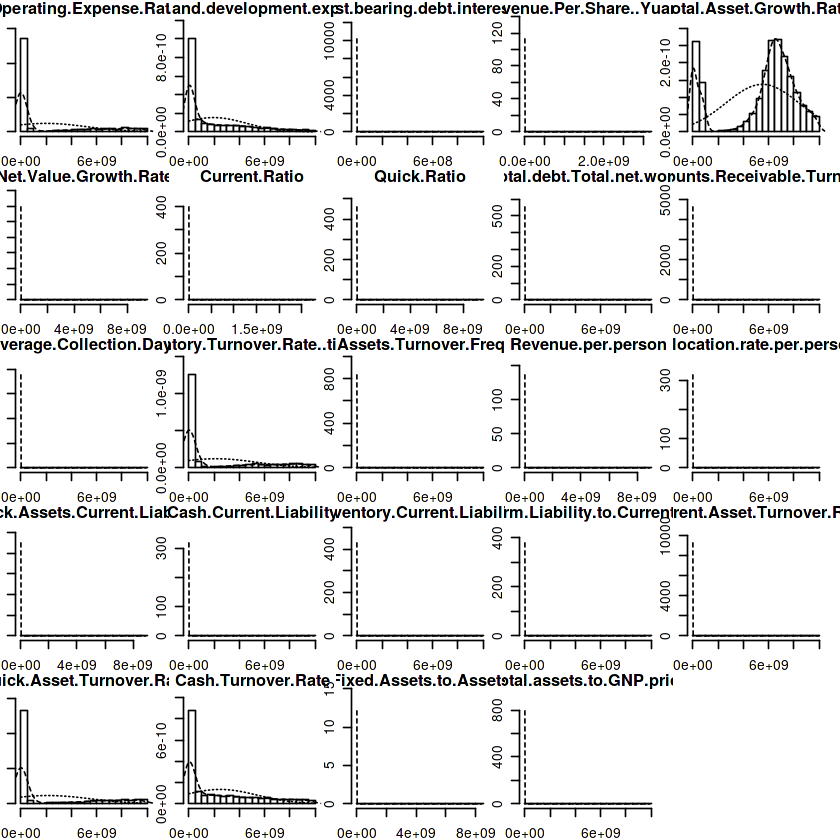

In [5]:
company %>% select(where(is.numeric)) %>% select_if(~mean(.) > 10) %>% multi.hist() 

Some of them are too imbalanced, others have extreme value. "Total.Asset.Growth.Rate" seems to be the only normal variable.

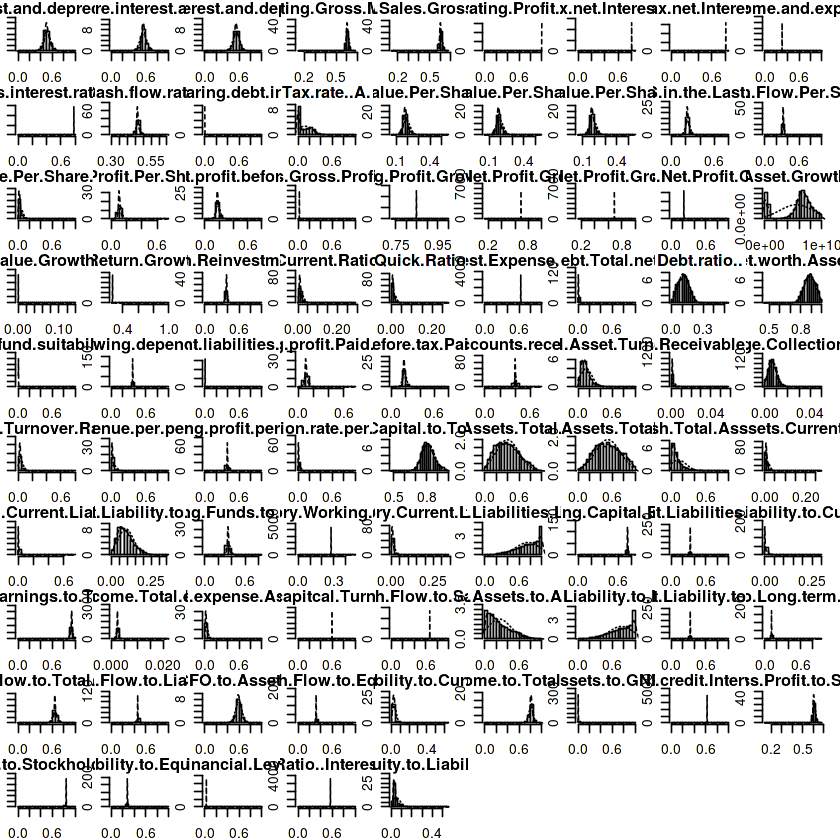

In [6]:
company %>% select(where(is.numeric) , -Total.Asset.Growth.Rate) %>% select_if(~mean(.) > 10^8) %>% colnames() -> abnormal_col
company %>% select(-c(all_of(abnormal_col))) -> company_processed #remove imbalanced variables
company_processed %>% select(where(is.numeric)) %>% select_if(~mean(.) > 10) %>% select(-Total.Asset.Growth.Rate) %>% colnames() -> abnormal_col 
company_processed %>% filter_at(vars(all_of(abnormal_col)) , all_vars(. < 10)) -> company_processed #remove observations have outliers
company_processed %>% select(where(is.numeric)) %>% multi.hist()

Done.

### Variable selection

You don't want to go ahead with the data because there're still a lot of variables. Anyway, you should remove some of them to do better analysis. However, the selection is quite challenging. To do that, selection the variable by your own hands would be better.

In [7]:
company_processed %>% select(Bankrupt. , ROA.B..before.interest.and.depreciation.after.tax, Operating.Gross.Margin, Net.Value.Per.Share..A.,
Realized.Sales.Gross.Profit.Growth.Rate, Total.Asset.Growth.Rate, Net.Value.Growth.Rate, Quick.Ratio, Debt.ratio..,
Revenue.per.person, Long.term.Liability.to.Current.Assets, Total.income.Total.expense, Liability.to.Equity, Equity.to.Liability) -> company_remove_col

 ### SMOTE

The dependent variable is too imbalanced. That is also a problem. If you keep going without solveing this issue, the model might not predict bankruptcy correctly.

In [8]:
company_remove_col %>% initial_split(0.7) -> com_split # Split as training and test

com_split %>% training() %>% recipe(Bankrupt. ~.) %>% step_corr(all_predictors()) %>%
  step_center(all_predictors() , -all_outcomes()) %>% step_scale(all_predictors() , -all_outcomes()) %>% prep() -> com_recipe # Recipe

com_recipe %>% juice -> com_training # training data
com_recipe %>% bake(com_split %>% testing()) -> com_test # test data

rose <- ROSE(Bankrupt. ~ . , data = com_training , seed = 4) # SMOTE
com_rose <- rose$data 


### Validation

In [9]:
# Prepare validation set

com_rose %>% vfold_cv(v = 10) -> com_vfold #Generate V-Fold data
com_vfold %>% mutate(com_ana = map(splits,analysis), com_ass = map(splits,assessment)) -> com_val

# Modeling

### Random forest

In [10]:
#Validation

rand_forest_model <- rand_forest() %>% set_engine('randomForest') %>% set_mode('classification') # Modeling
com_val %>% mutate(
  recipe = map(com_ana, ~prep(com_recipe, training = .x)),
  com_ana = map(recipe, juice),
  com_ass = map2(recipe, com_ass, ~bake(.x , new_data = .y))) %>%
  mutate(com_fit = map(com_ana, ~fit(rand_forest_model, Bankrupt. ~. , data = .x))) %>%
  mutate(model_pred = map2(com_fit, com_ass, ~predict(.x, new_data = .y))) -> com_val # Prepare validation

com_val %>% mutate(res = map2(com_ass, model_pred, ~data.frame(Bankrupt. = .x$Bankrupt., pred = .y$.pred_class))) %>% 
select(id, res) %>% 
unnest(res) %>% 
group_by(id) -> com_pred

metrics(com_pred, truth = Bankrupt., estimate = pred) # Metrics for validation

id,.metric,.estimator,.estimate
<chr>,<chr>,<chr>,<dbl>
Fold01,accuracy,binary,0.8318182
Fold02,accuracy,binary,0.8295455
Fold03,accuracy,binary,0.8113636
Fold04,accuracy,binary,0.8136364
Fold05,accuracy,binary,0.7886364
Fold06,accuracy,binary,0.8272727
Fold07,accuracy,binary,0.8204545
Fold08,accuracy,binary,0.8291572
Fold09,accuracy,binary,0.8018223


Validation worked.

### Test

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6666667
precision,binary,0.9958506
recall,binary,0.6582556
f_meas,binary,0.7926024
.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6555202
precision,binary,0.9957770
recall,binary,0.6467361


[1] "The mean of bankrupt_accuracy : 0.921311475409836"

Area under the curve (AUC): 0.787

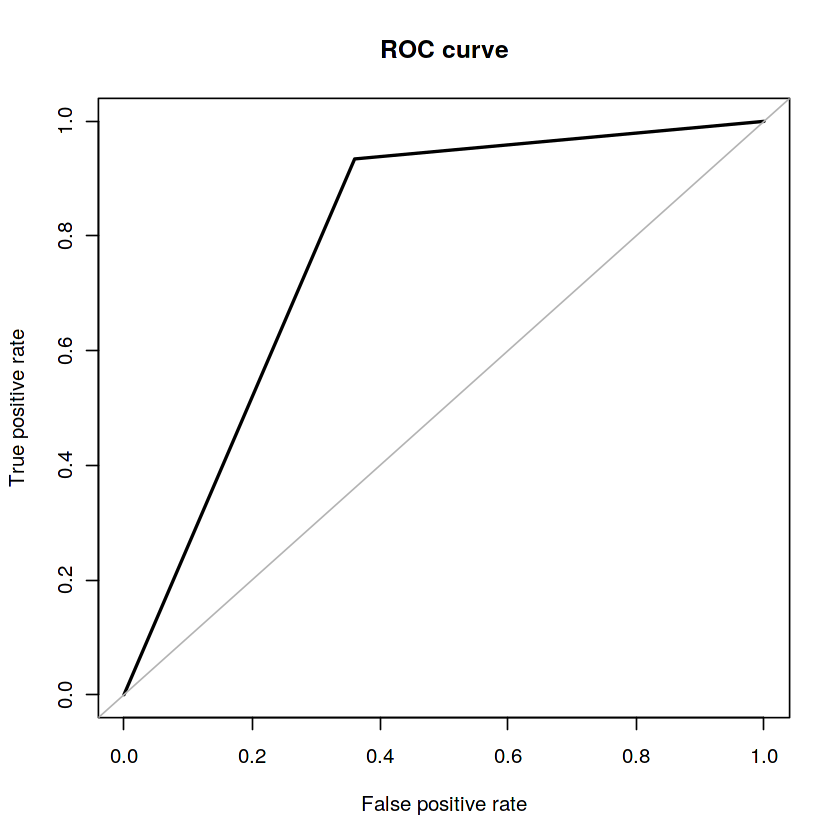

In [11]:
result <- list()
bankrupt_accuracy <- vector()
for(i in 1:10){

rand_forest_model %>% fit(Bankrupt. ~ . , data = com_rose) -> com_rf
com_rf %>% predict(com_test) %>% bind_cols(com_test %>% select(Bankrupt.)) -> com_pre

accu <- accuracy(com_pre, truth = Bankrupt., estimate = .pred_class)
prec <- yardstick::precision(com_pre, truth = Bankrupt., estimate = .pred_class)
rec <- yardstick::recall(com_pre, truth = Bankrupt., estimate = .pred_class)
f1 <- f_meas(com_pre, truth = Bankrupt., estimate = .pred_class)
result[[i]] <- bind_rows(accu,prec,rec,f1)

com_pre %>% conf_mat(Bankrupt., .pred_class) %>% pluck(1) %>% as_tibble() %>% spread(Truth, n) -> conf_matrix
bankrupt_accuracy <- c(bankrupt_accuracy , conf_matrix$YES[2] /sum(conf_matrix$YES))    

}

result
paste0('The mean of bankrupt_accuracy : ' ,mean(bankrupt_accuracy))
roc.curve(response = com_test$Bankrupt. , predicted = com_pre$.pred_class)

# Conclusion

The model we made doesn't have high accuracy. But it does predict correctly bankrupt companies would go bankrupt. Thus, it's not good for the analysis itself but it's kind of useful for reality.